# Business problem :Create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot by CNN


## PRCP- 1001- RiceLeaf disease detection

### Problem Statement

Task 1:-Prepare a complete data analysis report on the given data.

Task 2:-Create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot.

Task3:- Analyze various techniques like Data Augmentation, etc and create a report on that.

# Domain Analysis

This dataset contains 120 jpg images of disease-infected rice leaves.It is a multi class classification task. The images are grouped into 3 classes based on the type of disease. There are 40 images in each class. Classes ● Leaf smut ● Brown spot ● Bacterial leaf blight

##### Classes

1.Leaf smut :-It is caused by the Gram-negative bacterium Xanthomonas oryzae pv.It causes wilting of seedlings and yellowing and drying of leaves.

2.Brown spot :- Brown spot is a fungal disease that infects the coleoptile, leaves, leaf sheath, panicle branches, glumes, and spikelets. Its most observable damage is the numerous big spots on the leaves which can kill the whole leaf. 

3.Bacterial leaf blight :- Leaf smut, caused by the fungus Entyloma oryzae, is a widely distributed, but somewhat minor, disease of rice. The fungus produces slightly raised, angular, black spots (sori) on both sides of the leaves 

## **Import Libraries**

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
#from IPython.display import HTML
import os
import numpy as np


## **Set all the Constants**

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=100

## Loading Data

In [4]:
data= tf.keras.preprocessing.image_dataset_from_directory("Data",seed=123,shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)

Found 119 files belonging to 3 classes.


In [5]:
len(data)

4

In [6]:
Class_names = data.class_names#will retuen the name of classes.
Class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [7]:
for image_batch, labels_batch in data.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 2 2 1 0 1 0 1 1 1 2 0 1 0 1 1 1 0 0 2 2 1 2 1 1 1 2 0 2 0 0]


## Visualize some of the images from our dataset

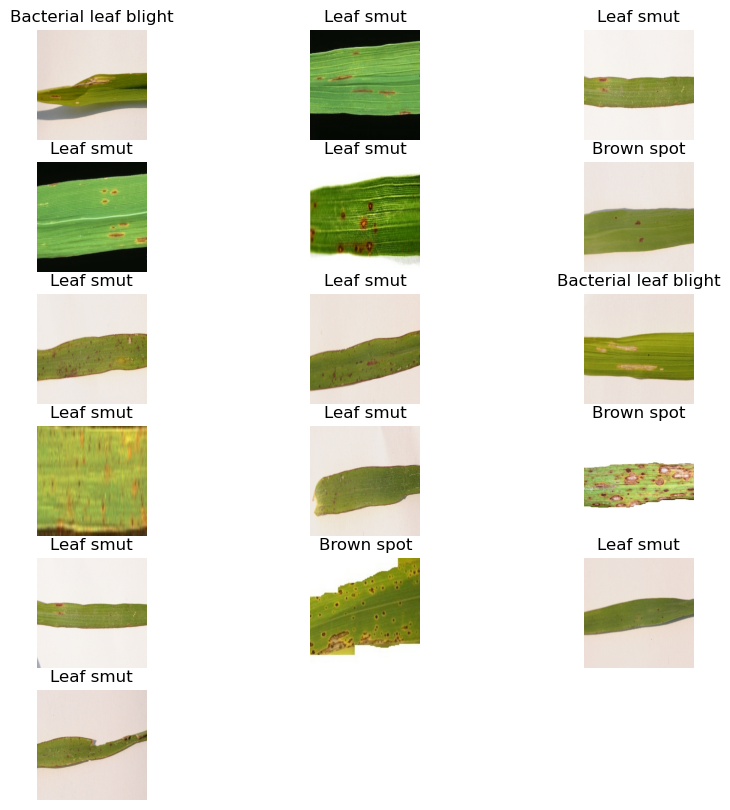

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data.take(1):
    for i in range(16):
        ax = plt.subplot(6, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(Class_names[labels_batch[i]]) #label the images 
        plt.axis("off")#Hiding the axis numbers

## Splitting the  Data

1.Training: Dataset to be used while training.

2.Validation: Dataset to be tested against while training.

3.Test: Dataset to be tested against after we trained a model.

In [9]:
#splitting the data into train=80% ,val=10%, test=10% 
def splitting_data(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=16)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = splitting_data(data)

## Cache, Shuffle, and Prefetch the Data

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Scaling the data


In [12]:
#data Prepocessing
#resize will take care of any image passes in prediction wich is of different dimension  and will resize to IMAGE_SIZE
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation


In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),])

## Applying Data Augmentation to Train Dataset

In [14]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True),
        y)).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Build Deep Learning Model 

#### CNN

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = 3

model = models.Sequential([
    resize_and_rescale,data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
   
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

## Compiling the Model


In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Traning the Model

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,#no of times the model is needed to be evaluated during training.
)

Epoch 1/100
3/3 [==============================] - 29s 9s/step - loss: 1.1338 - accuracy: 0.3103
Epoch 2/100
3/3 [==============================] - 14s 5s/step - loss: 1.1056 - accuracy: 0.3448
Epoch 3/100
3/3 [==============================] - 13s 4s/step - loss: 1.0974 - accuracy: 0.2989
Epoch 4/100
3/3 [==============================] - 12s 4s/step - loss: 1.0773 - accuracy: 0.4138
Epoch 5/100
3/3 [==============================] - 10s 4s/step - loss: 1.0298 - accuracy: 0.3793
Epoch 6/100
3/3 [==============================] - 14s 6s/step - loss: 1.0376 - accuracy: 0.5632
Epoch 7/100
3/3 [==============================] - 16s 5s/step - loss: 0.9977 - accuracy: 0.5057
Epoch 8/100
3/3 [==============================] - 14s 4s/step - loss: 0.9287 - accuracy: 0.6667
Epoch 9/100
3/3 [==============================] - 11s 3s/step - loss: 0.8840 - accuracy: 0.6437
Epoch 10/100
3/3 [==============================] - 17s 6s/step - loss: 0.8543 - accuracy: 0.6207
Epoch 11/100
3/3 [===========

3/3 [==============================] - 11s 3s/step - loss: 0.1361 - accuracy: 0.9655
Epoch 67/100
3/3 [==============================] - 11s 4s/step - loss: 0.1055 - accuracy: 0.9655
Epoch 68/100
3/3 [==============================] - 11s 3s/step - loss: 0.1153 - accuracy: 0.9770
Epoch 69/100
3/3 [==============================] - 11s 4s/step - loss: 0.2473 - accuracy: 0.9195
Epoch 70/100
3/3 [==============================] - 11s 3s/step - loss: 0.1904 - accuracy: 0.9080
Epoch 71/100
3/3 [==============================] - 10s 3s/step - loss: 0.1936 - accuracy: 0.8851
Epoch 72/100
3/3 [==============================] - 11s 4s/step - loss: 0.1529 - accuracy: 0.9425
Epoch 73/100
3/3 [==============================] - 11s 4s/step - loss: 0.1752 - accuracy: 0.9195
Epoch 74/100
3/3 [==============================] - 11s 4s/step - loss: 0.1934 - accuracy: 0.9080
Epoch 75/100
3/3 [==============================] - 11s 3s/step - loss: 0.2393 - accuracy: 0.8851
Epoch 76/100
3/3 [===============

In [19]:
history

In [20]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 3}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [22]:
history.history['accuracy']

[0.3103448152542114,
 0.3448275923728943,
 0.29885056614875793,
 0.4137931168079376,
 0.37931033968925476,
 0.5632184147834778,
 0.5057471394538879,
 0.6666666865348816,
 0.6436781883239746,
 0.6206896305084229,
 0.5747126340866089,
 0.7126436829566956,
 0.5862069129943848,
 0.6436781883239746,
 0.6551724076271057,
 0.7471264600753784,
 0.7701149582862854,
 0.7471264600753784,
 0.7356321811676025,
 0.7471264600753784,
 0.7471264600753784,
 0.7586206793785095,
 0.8045976758003235,
 0.8045976758003235,
 0.8275862336158752,
 0.8045976758003235,
 0.7586206793785095,
 0.7816091775894165,
 0.7816091775894165,
 0.8045976758003235,
 0.8045976758003235,
 0.7931034564971924,
 0.8045976758003235,
 0.8275862336158752,
 0.8390804529190063,
 0.8850574493408203,
 0.8390804529190063,
 0.8045976758003235,
 0.8390804529190063,
 0.8275862336158752,
 0.8735632300376892,
 0.8045976758003235,
 0.8045976758003235,
 0.8275862336158752,
 0.8735632300376892,
 0.8620689511299133,
 0.8390804529190063,
 0.82758623

## Model Evaluation

In [23]:
scores_train = model.evaluate(train_ds)
print('Train loss:', scores_train[0]) 
print('Train accuracy:', scores_train[1])


3/3 [==============================] - 14s 821ms/step - loss: 0.1388 - accuracy: 0.9425
Train loss: 0.13878630101680756
Train accuracy: 0.9425287246704102


In [24]:
scores_test = model.evaluate(test_ds)
print('Test loss:', scores_test[0]) 
print('Test accuracy:', scores_test[1])


1/1 [==============================] - 4s 4s/step - loss: 0.2613 - accuracy: 0.9062
Test loss: 0.26133501529693604
Test accuracy: 0.90625


##### The test accuracy is 90%. We have created a best model to identify the three major attacking diseases of rice plants. On the positive side, we can still scope to improve our model.



## Plotting the accuracy and loss curve

In [25]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["accuracy"]
loss = history.history["loss"]
val_loss = history.history["loss"]
epochs = range(1, len(accuracy) + 1)


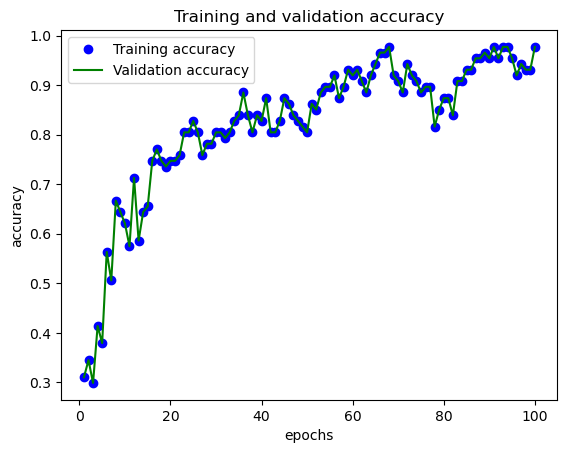

In [26]:
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "g", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()


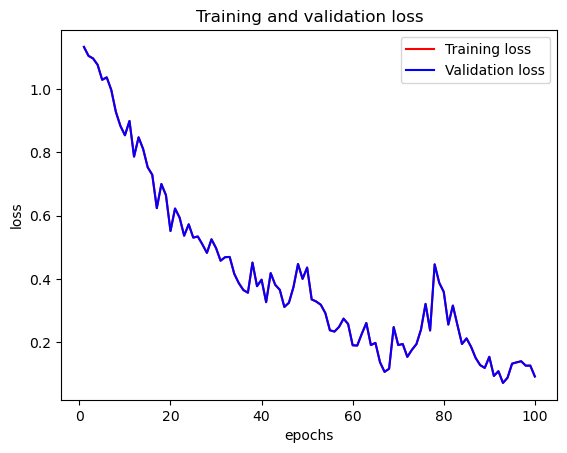

In [27]:
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

## Run prediction on a sample image

first image to predict
actual label: Leaf smut
1/1 [==============================] - 2s 2s/step
predicted label: Leaf smut


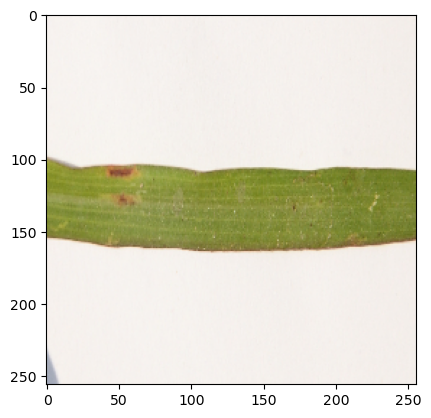

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",Class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",Class_names[np.argmax(batch_prediction[1])])

##### The output is identical and it indicate our model correctly predicts the  image.


### Function for inference

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = Class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 54ms/step


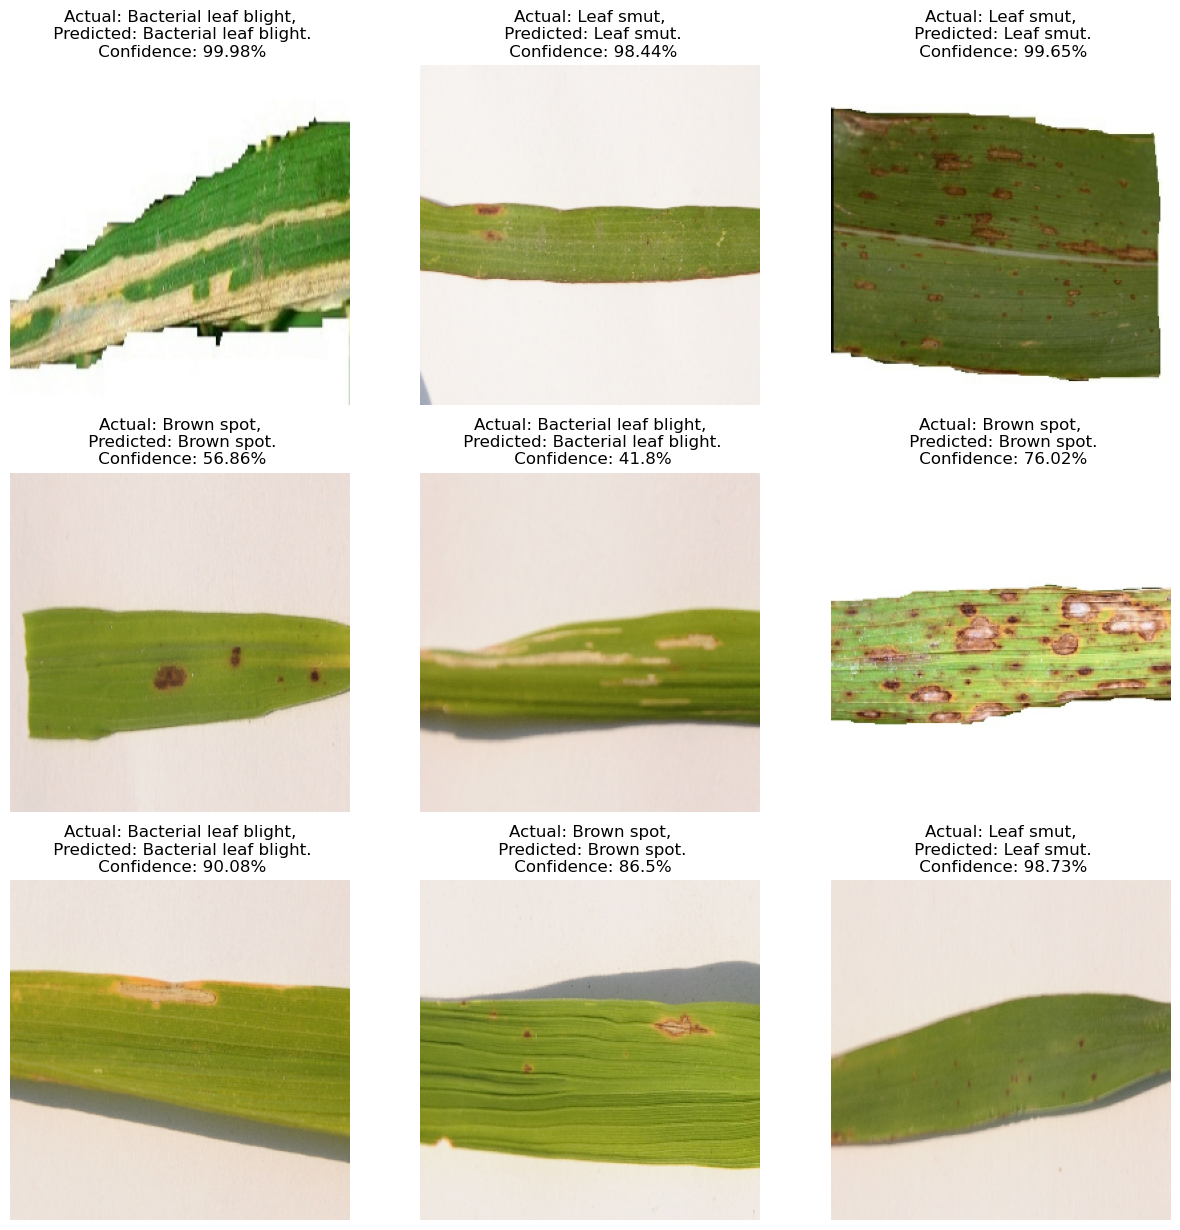

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = Class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

##### The Prediction is identical to the actual, that indicate our model correctly predicts the images.


# Saving the Model

In [31]:
model_version=1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets


In [ ]:
import os
model_version=max([int(i) for i in os.listdir()+[0]])+1
model.save(f'..model/{model_version}')

## Conclusion